In [22]:
import pandas as pd
import numpy as np
import math
import h5py
import tempfile

import tensorflow as tf
import tensorflow_model_optimization as tfmot
from sklearn.model_selection import train_test_split
print(tf.__version__)
from tensorflow.keras.models import Sequential, Model,model_from_json
from keras.layers import Input,Dense, BatchNormalization, Activation, LeakyReLU
from keras import initializers, regularizers, optimizers, losses
from nn_globals import *
from nn_encode_displ import nlayers, nvariables
from nn_training import train_model
from nn_models import load_my_model, update_keras_custom_objects, lr_decay, modelbestcheck_weights, modelbestcheck
from keras.models import Model
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Setup matplotlib
plt.style.use('tdrstyle.mplstyle')

from nn_plotting import (gaus, fit_gaus, np_printoptions, \
                         find_efficiency_errors)

eps = 1e-7
my_cmap = plt.cm.viridis
my_cmap.set_under('w',1)
my_palette = ("#377eb8", "#e41a1c", "#984ea3", "#ff7f00", "#4daf4a")

2.4.1


<ipython-input-22-b0bcf385fb82>:29: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  my_cmap.set_under('w',1)


In [23]:
class evaluate:
    def __init__(self,X_test,y_test):
        self.X = X_test
        self.y = y_test[0]
        self.dxy = y_test[1]
    
    def compute_data_statistics(self,ctype = "y",label="data"):
        if ctype == "y":
            x = self.recalibrate(self.y,reg_pt_scale)
            x = x**(-1)
        else:
            x = self.recalibrate(self.dxy,reg_dxy_scale)
        df_describe = pd.DataFrame(x, columns = [label])
        print(df_describe.describe())
    
    def rmse(self,y_true, y_predicted):
        assert(y_true.shape[0] == y_predicted.shape[0])
        n = y_true.shape[0]
        sum_square = np.sum((y_true - y_predicted)**2)
        return math.sqrt(sum_square/n)
    
    def adjusted_r_2(self,y_true, y_predicted):
        y_addC = sm.add_constant(y_true)
        result = sm.OLS(y_predicted, y_addC).fit()
        print(result.rsquared, result.rsquared_adj)

    def recalibrate(self,x,scale):
        return x/scale
    
    def inverse(self,arr):
        arr_inv = 1./arr
        arr_inv[arr_inv == np.inf] = 0.
        return arr_inv
    
    def predict(self,model,batch_size = 256):
        y_test_true = self.recalibrate(self.y,reg_pt_scale)
        dxy_test_true = self.recalibrate(self.dxy, reg_dxy_scale)
        
        y_test = model.predict(self.X,batch_size = 2000)
        y_test_meas = y_test[:,0]
        dxy_test_meas = y_test[:,1]
        y_test_meas = self.recalibrate(y_test_meas,reg_pt_scale)
        dxy_test_meas = self.recalibrate(dxy_test_meas,reg_dxy_scale)   
    
        y_test_meas = y_test_meas.reshape(-1)
        dxy_test_meas = dxy_test_meas.reshape(-1)

        return y_test_meas, dxy_test_meas
class evaluate:
    def __init__(self,X_test,y_test):
        self.X = X_test
        self.y = y_test[0]
        self.dxy = y_test[1]
    
    def compute_data_statistics(self,ctype = "y",label="data"):
        if ctype == "y":
            x = self.recalibrate(self.y,reg_pt_scale)
            x = x**(-1)
        else:
            x = self.recalibrate(self.dxy,reg_dxy_scale)
        df_describe = pd.DataFrame(x, columns = [label])
        print(df_describe.describe())
    
    def rmse(self,y_true, y_predicted):
        assert(y_true.shape[0] == y_predicted.shape[0])
        n = y_true.shape[0]
        sum_square = np.sum((y_true - y_predicted)**2)
        return math.sqrt(sum_square/n)
    
    def adjusted_r_2(self,y_true, y_predicted):
        y_addC = sm.add_constant(y_true)
        result = sm.OLS(y_predicted, y_addC).fit()
        print(result.rsquared, result.rsquared_adj)

    def recalibrate(self,x,scale):
        return x/scale
    
    def inverse(self,arr):
        arr_inv = 1./arr
        arr_inv[arr_inv == np.inf] = 0.
        return arr_inv
    
    def predict(self,model,batch_size = 256):
        y_test_true = self.recalibrate(self.y,reg_pt_scale)
        dxy_test_true = self.recalibrate(self.dxy, reg_dxy_scale)
        
        y_test = model.predict(self.X,batch_size = 2000)
        y_test_meas = y_test[:,0]
        dxy_test_meas = y_test[:,1]
        y_test_meas = self.recalibrate(y_test_meas,reg_pt_scale)
        dxy_test_meas = self.recalibrate(dxy_test_meas,reg_dxy_scale)   
    
        y_test_meas = y_test_meas.reshape(-1)
        dxy_test_meas = dxy_test_meas.reshape(-1)

        return y_test_meas, dxy_test_meas
    
    def compute_error(self,y_predicted,ctype = "y"):
        if ctype == "y":
            y_test_true = self.recalibrate(self.y,reg_pt_scale)
            print("RMSE Error for momentum:",self.rmse(self.inverse(y_test_true),\
                                                                              self.inverse(y_predicted)))
        else:
            dxy_test_true = self.recalibrate(self.dxy, reg_dxy_scale)
            print("RMSE Error for dxy:",self.rmse(dxy_test_true,y_predicted))

    def get_error(self,y_predicted,ctype = "y"):
        if ctype == "y":
            y_test_true = self.recalibrate(self.y,reg_pt_scale)
            return self.rmse(self.inverse(y_test_true),self.inverse(y_predicted))
        else:
            dxy_test_true = self.recalibrate(self.dxy, reg_dxy_scale)
            return self.rmse(dxy_test_true,y_predicted)


def k_fold_validation(model, x, y, dxy, folds =10):
    x_copy = np.copy(x)
    y_copy = np.copy(y)
    dxy_copy = np.copy(dxy)
    assert x_copy.shape[0] == y_copy.shape[0] == dxy_copy.shape[0]
    fold_size = int(x_copy.shape[0] / folds)
    x_splits, y_splits, dxy_splits = [], [], []
    for i in range(folds):
        indices = np.random.choice(x_copy.shape[0],fold_size, replace=False)  
        x_splits.append(x_copy[indices])
        y_splits.append(y_copy[indices])
        dxy_splits.append(dxy_copy[indices])
        x_copy = np.delete(x_copy,indices,axis = 0)
        y_copy = np.delete(y_copy,indices,axis = 0)
        dxy_copy = np.delete(dxy_copy,indices,axis = 0)
    rmse_y, rmse_dxy = [],[]
    for i in range(folds):
        evaluate_obj = evaluate(x_splits[i], tuple([y_splits[i],dxy_splits[i]]))
        y_predicted , dxy_predicted = evaluate_obj.predict(model = model)
        rmse_y.append(evaluate_obj.get_error(y_predicted,ctype="y"))
        rmse_dxy.append(evaluate_obj.get_error(dxy_predicted,ctype="dxy"))
    print('Average RMSE for '+ str(folds) + '-fold cv for y:', np.mean(rmse_y))
    print('Average RMSE for '+ str(folds) + '-fold cv for dxy:', np.mean(rmse_dxy))

### Package Installations:

In [24]:
# !pip install numpy 
# !pip install matplotlib
# !pip install -q tensorflow-model-optimization
# !pip install pandas
# !pip install statsmodels

### Preprocessing the inputs:

In [25]:
infile_muon_displ = "NN_input_params_FlatXYZ.npz"

nentries = 100000000

def _handle_nan_in_x(x):
    x[np.isnan(x)] = 0.0
    x[x==-999.0] = 0.0
    return x

def _zero_out_x(x):
    x = 0.0
    return x
    
def _fixME1Ring(x):
    for i in range(len(x)):
        if (x[i,0] != 0.0): x[i,18] = x[i,18] + 1
    return x   

def muon_data(filename, reg_pt_scale=1.0, reg_dxy_scale=1.0, correct_for_eta=False):
    try:
        logger.info('Loading muon data from {0} ...'.format(filename))
        loaded = np.load(filename)
        the_variables = loaded['variables']
        the_parameters = loaded['parameters']
        # print(the_variables.shape)
        the_variables = the_variables[:nentries]
        the_parameters = the_parameters[:nentries]
        logger.info('Loaded the variables with shape {0}'.format(the_variables.shape))
        logger.info('Loaded the parameters with shape {0}'.format(the_parameters.shape))
    except:
        logger.error('Failed to load data from file: {0}'.format(filename))

    assert(the_variables.shape[0] == the_parameters.shape[0])
    _handle_nan_in_x(the_variables)
      #_fixME1Ring(the_variables)
    _handle_nan_in_x(the_parameters)
    mask = np.logical_or(np.logical_or( np.logical_or((the_variables[:,23] == 11), (the_variables[:,23] == 13)), (the_variables[:,23] == 14)),(the_variables[:,23] == 15)) 

    the_variables = the_variables[mask]  
    the_parameters = the_parameters[mask]  
    assert(the_variables.shape[0] == the_parameters.shape[0])

    x = the_variables[:,0:23]
    y = reg_pt_scale*the_parameters[:,0]
#     print (x[0:30,:], the_variables[0:30,23])
#     print (y[0:30])
    phi = the_parameters[:,1] 
    eta = the_parameters[:,2] 
    vx = the_parameters[:,3] 
    vy = the_parameters[:,4] 
    vz = the_parameters[:,5]      
    dxy = vy * np.cos(phi) - vx * np.sin(phi) 
    dz = vz
    w = np.abs(y)/0.2 + 1.0
    x_mask = the_parameters[:,5]
    x_road = the_parameters[:,5] 
    _zero_out_x(x_mask)
    _zero_out_x(x_road)  
    logger.info('Loaded the encoded variables with shape {0}'.format(x.shape))
    logger.info('Loaded the encoded parameters with shape {0}'.format(y.shape))
    #assert(np.isfinite(x).all())
    return x, y, dxy, dz, w, x_mask, x_road

def muon_data_split(filename, reg_pt_scale=1.0, reg_dxy_scale=1.0, test_size=0.5, correct_for_eta=False):
    x, y, dxy, dz, w, x_mask, x_road = muon_data(filename, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale, correct_for_eta=correct_for_eta)

    # Split dataset in training and testing
    x_train, x_test, y_train, y_test, dxy_train, dxy_test, dz_train, dz_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test = train_test_split(x, y, dxy, dz, w, x_mask, x_road, test_size=test_size)
    logger.info('Loaded # of training and testing events: {0}'.format((x_train.shape[0], x_test.shape[0])))

    # Check for cases where the number of events in the last batch could be too few
    validation_split = 0.1
    train_num_samples = int(x_train.shape[0] * (1.0-validation_split))
    val_num_samples = x_train.shape[0] - train_num_samples
    batch_size = 128
    if (train_num_samples%batch_size) < 100:
        logger.warning('The last batch for training could be too few! ({0}%{1})={2}. Please change test_size.'.format(train_num_samples, batch_size, train_num_samples%batch_size))
        logger.warning('Try this formula: int(int({0}*{1})*{2}) % 128'.format(x.shape[0], 1.0-test_size, 1.0-validation_split))
    train_num_samples = int(x_train.shape[0] * 2 * (1.0-validation_split))
    val_num_samples = x_train.shape[0] - train_num_samples
    batch_size = 128
    if (train_num_samples%batch_size) < 100:
        logger.warning('The last batch for training after mixing could be too few! ({0}%{1})={2}. Please change test_size.'.format(train_num_samples, batch_size, train_num_samples%batch_size))
        logger.warning('Try this formula: int(int({0}*{1})*2*{2}) % 128'.format(x.shape[0], 1.0-test_size, 1.0-validation_split))
    return x_train, x_test, y_train, y_test, dxy_train, dxy_test, dz_train, dz_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test

# Import muon data
# 'x' is the array of input variables, 'y' is the q/pT
x_train_displ, x_test_displ, y_train_displ, y_test_displ, dxy_train_displ, dxy_test_displ, dz_train_displ, dz_test_displ, \
w_train_displ, w_test_displ, x_mask_train_displ, x_mask_test_displ, x_road_train_displ, x_road_test_displ = \
      muon_data_split(infile_muon_displ, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale, test_size=0.315)

y_train_displ = np.abs(y_train_displ)
y_test_displ = np.abs(y_test_displ)


[INFO    ] Loading muon data from NN_input_params_FlatXYZ.npz ...
[INFO    ] Loaded the variables with shape (19300000, 25)
[INFO    ] Loaded the parameters with shape (19300000, 6)
[INFO    ] Loaded the encoded variables with shape (3284620, 23)
[INFO    ] Loaded the encoded parameters with shape (3284620,)
[INFO    ] Loaded # of training and testing events: (2249964, 1034656)
[WARNING ] The last batch for training could be too few! (2024967%128)=7. Please change test_size.
[WARNING ] Try this formula: int(int(3284620*0.685)*0.9) % 128
[WARNING ] The last batch for training after mixing could be too few! (4049935%128)=15. Please change test_size.
[WARNING ] Try this formula: int(int(3284620*0.685)*2*0.9) % 128


### Training Algorithm for the non-pruned model:

In [26]:
def huber_loss(y_true, y_pred, delta=1.345):
    x = K.abs(y_true - y_pred)
    squared_loss = 0.5*K.square(x)
    absolute_loss = delta * (x - 0.5*delta)
    #xx = K.switch(x < delta, squared_loss, absolute_loss)
    xx = tf.where(x < delta, squared_loss, absolute_loss)  # needed for tensorflow
    return K.mean(xx, axis=-1)

In [27]:
def create_model(nvariables, lr=0.001, clipnorm=10., nodes1=64, nodes2=32, nodes3=16, nodes4=0, nodes5=0, 
                 outnodes=2, l1_reg=0.0, l2_reg=0.0, use_bn=True, kernel_initializer = "he_uniform",
                 eps = 1e-4, momentum = 0.9, activation = "tanh",use_dropout=False):
    # Adding 1 BN layer right after the input layer
    regularizer = regularizers.L1L2(l1=l1_reg, l2=l2_reg)
    model = Sequential()  
    if use_bn: 
        model.add(BatchNormalization(input_shape=(nvariables,), epsilon=eps, momentum=momentum))
    model.add(Dense(nodes1, kernel_initializer=kernel_initializer, kernel_regularizer=regularizer, use_bias=False))
    if use_bn: 
        model.add(BatchNormalization(epsilon=eps, momentum=momentum))
#     model.add(Activation(activation))
    model.add(LeakyReLU(alpha = .25))
    if nodes2:
        model.add(Dense(nodes2, kernel_initializer=kernel_initializer, kernel_regularizer=regularizer, use_bias=False))
        if use_bn: 
            model.add(BatchNormalization(epsilon=eps, momentum=momentum))
#         model.add(Activation(activation))
        model.add(LeakyReLU(alpha = .25))
        if nodes3:
            model.add(Dense(nodes3, kernel_initializer=kernel_initializer, kernel_regularizer=regularizer, use_bias=False))
            if use_bn: 
                model.add(BatchNormalization(epsilon=eps, momentum=momentum))
#             model.add(Activation(activation))
            model.add(LeakyReLU(alpha = .25))
            if nodes4:
                model.add(Dense(nodes4, kernel_initializer=kernel_initializer, kernel_regularizer=regularizer, use_bias=False))
                if use_bn: 
                    model.add(BatchNormalization(epsilon=eps, momentum=momentum))
#                 model.add(Activation(activation))
                model.add(LeakyReLU(alpha = .25))
                if nodes5:
                    model.add(Dense(nodes5, kernel_initializer=kernel_initializer, kernel_regularizer=regularizer, use_bias=False))
                    if use_bn: 
                        model.add(BatchNormalization(epsilon=eps, momentum=momentum))
#                     model.add(Activation(activation))     
                    model.add(LeakyReLU(alpha = .25))
     
    # Output node
    model.add(Dense(outnodes, activation='linear', kernel_initializer=kernel_initializer))

    # Set loss and optimizers
    adam = optimizers.Adam(lr=lr, clipnorm=clipnorm)
    model.compile(optimizer=adam, loss=huber_loss, metrics=['acc'])
    model.summary()
    return model

In [28]:
assert(keras.backend.backend() == 'tensorflow')

lr = 1e-3
l1_reg = 0.0
l2_reg = 0.0
clipnorm = 10.
eps = 1e-4
momentum = 0.9
normal_epochs = 300
normal_batch_size = 500

model = create_model(nvariables=nvariables, 
                    lr=learning_rate, 
                    clipnorm=gradient_clip_norm, 
                    l1_reg=l1_reg, 
                    l2_reg=l2_reg,
                    nodes1=20, 
                    nodes2=15, 
                    nodes3=10, 
                    outnodes=2, 
                    activation = "selu",
                    eps = eps,
                    kernel_initializer = "lecun_uniform",
                    momentum = momentum)

logger.info('Training model with l1_reg: {0} l2_reg: {0}'.format(l1_reg, l2_reg))

history = train_model(model, 
                      x_train_displ, 
                      np.column_stack((y_train_displ, dxy_train_displ)),
                      epochs=normal_epochs, 
                      batch_size=normal_batch_size,
                      callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], 
                      validation_split=0.1, 
                      verbose=2)

metrics = [len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]]
logger.info('Epoch {0}/{0} - loss: {1} - val_loss: {2}'.format(*metrics))

[INFO    ] Training model with l1_reg: 0.0 l2_reg: 0.0
[INFO    ] Begin training ...


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_8 (Batch (None, 23)                92        
_________________________________________________________________
dense_8 (Dense)              (None, 20)                460       
_________________________________________________________________
batch_normalization_9 (Batch (None, 20)                80        
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 20)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 15)                300       
_________________________________________________________________
batch_normalization_10 (Batc (None, 15)                60        
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 15)               


Epoch 00023: val_loss did not improve from 9.73163

Epoch 00023: val_loss did not improve from 9.73163
Epoch 24/300

Epoch 00024: LearningRateScheduler reducing learning rate to 0.005102999974042177.
4050/4050 - 5s - loss: 10.4886 - acc: 0.9364 - val_loss: 10.0302 - val_acc: 0.9392

Epoch 00024: val_loss did not improve from 9.73163

Epoch 00024: val_loss did not improve from 9.73163
Epoch 25/300

Epoch 00025: LearningRateScheduler reducing learning rate to 0.005102999974042177.
4050/4050 - 5s - loss: 10.4940 - acc: 0.9364 - val_loss: 10.0461 - val_acc: 0.9389

Epoch 00025: val_loss did not improve from 9.73163

Epoch 00025: val_loss did not improve from 9.73163
Epoch 26/300

Epoch 00026: LearningRateScheduler reducing learning rate to 0.005102999974042177.
4050/4050 - 5s - loss: 10.4912 - acc: 0.9365 - val_loss: 10.0014 - val_acc: 0.9389

Epoch 00026: val_loss did not improve from 9.73163

Epoch 00026: val_loss did not improve from 9.73163
Epoch 27/300

Epoch 00027: LearningRateSched


Epoch 00052: val_loss did not improve from 9.73163

Epoch 00052: val_loss did not improve from 9.73163
Epoch 53/300

Epoch 00053: LearningRateScheduler reducing learning rate to 0.0037200867664068937.
4050/4050 - 5s - loss: 10.3980 - acc: 0.9368 - val_loss: 9.9303 - val_acc: 0.9392

Epoch 00053: val_loss did not improve from 9.73163

Epoch 00053: val_loss did not improve from 9.73163
Epoch 54/300

Epoch 00054: LearningRateScheduler reducing learning rate to 0.0037200867664068937.
4050/4050 - 5s - loss: 10.3925 - acc: 0.9370 - val_loss: 9.9167 - val_acc: 0.9397

Epoch 00054: val_loss did not improve from 9.73163

Epoch 00054: val_loss did not improve from 9.73163
Epoch 55/300

Epoch 00055: LearningRateScheduler reducing learning rate to 0.0037200867664068937.
4050/4050 - 5s - loss: 10.4004 - acc: 0.9368 - val_loss: 10.0038 - val_acc: 0.9395

Epoch 00055: val_loss did not improve from 9.73163

Epoch 00055: val_loss did not improve from 9.73163
Epoch 56/300

Epoch 00056: LearningRateSche


Epoch 00081: val_loss did not improve from 9.73163

Epoch 00081: val_loss did not improve from 9.73163
Epoch 82/300

Epoch 00082: LearningRateScheduler reducing learning rate to 0.002711943117901683.
4050/4050 - 5s - loss: 10.3663 - acc: 0.9372 - val_loss: 9.8859 - val_acc: 0.9394

Epoch 00082: val_loss did not improve from 9.73163

Epoch 00082: val_loss did not improve from 9.73163
Epoch 83/300

Epoch 00083: LearningRateScheduler reducing learning rate to 0.002711943117901683.
4050/4050 - 5s - loss: 10.3658 - acc: 0.9371 - val_loss: 9.8894 - val_acc: 0.9398

Epoch 00083: val_loss did not improve from 9.73163

Epoch 00083: val_loss did not improve from 9.73163
Epoch 84/300

Epoch 00084: LearningRateScheduler reducing learning rate to 0.002711943117901683.
4050/4050 - 5s - loss: 10.3592 - acc: 0.9370 - val_loss: 9.8900 - val_acc: 0.9397

Epoch 00084: val_loss did not improve from 9.73163

Epoch 00084: val_loss did not improve from 9.73163
Epoch 85/300

Epoch 00085: LearningRateSchedule


Epoch 00110: val_loss did not improve from 9.73163

Epoch 00110: val_loss did not improve from 9.73163
Epoch 111/300

Epoch 00111: LearningRateScheduler reducing learning rate to 0.001977006392553449.
4050/4050 - 5s - loss: 10.3374 - acc: 0.9372 - val_loss: 9.8861 - val_acc: 0.9399

Epoch 00111: val_loss did not improve from 9.73163

Epoch 00111: val_loss did not improve from 9.73163
Epoch 112/300

Epoch 00112: LearningRateScheduler reducing learning rate to 0.0019770064391195774.
4050/4050 - 5s - loss: 10.3516 - acc: 0.9371 - val_loss: 9.8906 - val_acc: 0.9396

Epoch 00112: val_loss did not improve from 9.73163

Epoch 00112: val_loss did not improve from 9.73163
Epoch 113/300

Epoch 00113: LearningRateScheduler reducing learning rate to 0.0019770064391195774.
4050/4050 - 5s - loss: 10.3599 - acc: 0.9370 - val_loss: 9.8577 - val_acc: 0.9399

Epoch 00113: val_loss did not improve from 9.73163

Epoch 00113: val_loss did not improve from 9.73163
Epoch 114/300

Epoch 00114: LearningRateSc


Epoch 00139: val_loss did not improve from 9.73163

Epoch 00139: val_loss did not improve from 9.73163
Epoch 140/300

Epoch 00140: LearningRateScheduler reducing learning rate to 0.0016013751737773418.
4050/4050 - 5s - loss: 10.3383 - acc: 0.9372 - val_loss: 9.8828 - val_acc: 0.9398

Epoch 00140: val_loss did not improve from 9.73163

Epoch 00140: val_loss did not improve from 9.73163
Epoch 141/300

Epoch 00141: LearningRateScheduler reducing learning rate to 0.0014412376563996078.
4050/4050 - 5s - loss: 10.3393 - acc: 0.9372 - val_loss: 9.8481 - val_acc: 0.9400

Epoch 00141: val_loss did not improve from 9.73163

Epoch 00141: val_loss did not improve from 9.73163
Epoch 142/300

Epoch 00142: LearningRateScheduler reducing learning rate to 0.0014412376331165433.
4050/4050 - 5s - loss: 10.3339 - acc: 0.9374 - val_loss: 9.8487 - val_acc: 0.9396

Epoch 00142: val_loss did not improve from 9.73163

Epoch 00142: val_loss did not improve from 9.73163
Epoch 143/300

Epoch 00143: LearningRateS


Epoch 00168: val_loss did not improve from 9.73163

Epoch 00168: val_loss did not improve from 9.73163
Epoch 169/300

Epoch 00169: LearningRateScheduler reducing learning rate to 0.0011674024863168597.
4050/4050 - 6s - loss: 10.3341 - acc: 0.9375 - val_loss: 9.8456 - val_acc: 0.9398

Epoch 00169: val_loss did not improve from 9.73163

Epoch 00169: val_loss did not improve from 9.73163
Epoch 170/300

Epoch 00170: LearningRateScheduler reducing learning rate to 0.0011674024863168597.
4050/4050 - 6s - loss: 10.3271 - acc: 0.9373 - val_loss: 9.8443 - val_acc: 0.9400

Epoch 00170: val_loss did not improve from 9.73163

Epoch 00170: val_loss did not improve from 9.73163
Epoch 171/300

Epoch 00171: LearningRateScheduler reducing learning rate to 0.0010506622376851738.
4050/4050 - 7s - loss: 10.3192 - acc: 0.9373 - val_loss: 9.8487 - val_acc: 0.9400

Epoch 00171: val_loss did not improve from 9.73163

Epoch 00171: val_loss did not improve from 9.73163
Epoch 172/300

Epoch 00172: LearningRateS


Epoch 00197: val_loss did not improve from 9.73163

Epoch 00197: val_loss did not improve from 9.73163
Epoch 198/300

Epoch 00198: LearningRateScheduler reducing learning rate to 0.0008510363986715674.
4050/4050 - 5s - loss: 10.3227 - acc: 0.9374 - val_loss: 9.8376 - val_acc: 0.9399

Epoch 00198: val_loss did not improve from 9.73163

Epoch 00198: val_loss did not improve from 9.73163
Epoch 199/300

Epoch 00199: LearningRateScheduler reducing learning rate to 0.0008510363986715674.
4050/4050 - 5s - loss: 10.3201 - acc: 0.9373 - val_loss: 9.8843 - val_acc: 0.9399

Epoch 00199: val_loss did not improve from 9.73163

Epoch 00199: val_loss did not improve from 9.73163
Epoch 200/300

Epoch 00200: LearningRateScheduler reducing learning rate to 0.0008510363986715674.
4050/4050 - 5s - loss: 10.3220 - acc: 0.9372 - val_loss: 9.8349 - val_acc: 0.9403

Epoch 00200: val_loss did not improve from 9.73163

Epoch 00200: val_loss did not improve from 9.73163
Epoch 201/300

Epoch 00201: LearningRateS


Epoch 00226: val_loss did not improve from 9.73163

Epoch 00226: val_loss did not improve from 9.73163
Epoch 227/300

Epoch 00227: LearningRateScheduler reducing learning rate to 0.0006204055389389396.
4050/4050 - 5s - loss: 10.3179 - acc: 0.9372 - val_loss: 9.8687 - val_acc: 0.9399

Epoch 00227: val_loss did not improve from 9.73163

Epoch 00227: val_loss did not improve from 9.73163
Epoch 228/300

Epoch 00228: LearningRateScheduler reducing learning rate to 0.0006204055389389396.
4050/4050 - 5s - loss: 10.3078 - acc: 0.9374 - val_loss: 9.8230 - val_acc: 0.9401

Epoch 00228: val_loss did not improve from 9.73163

Epoch 00228: val_loss did not improve from 9.73163
Epoch 229/300

Epoch 00229: LearningRateScheduler reducing learning rate to 0.0006204055389389396.
4050/4050 - 5s - loss: 10.3152 - acc: 0.9374 - val_loss: 9.8641 - val_acc: 0.9398

Epoch 00229: val_loss did not improve from 9.73163

Epoch 00229: val_loss did not improve from 9.73163
Epoch 230/300

Epoch 00230: LearningRateS


Epoch 00255: val_loss did not improve from 9.73163

Epoch 00255: val_loss did not improve from 9.73163
Epoch 256/300

Epoch 00256: LearningRateScheduler reducing learning rate to 0.0004522755916696042.
4050/4050 - 5s - loss: 10.3023 - acc: 0.9373 - val_loss: 9.8317 - val_acc: 0.9401

Epoch 00256: val_loss did not improve from 9.73163

Epoch 00256: val_loss did not improve from 9.73163
Epoch 257/300

Epoch 00257: LearningRateScheduler reducing learning rate to 0.0004522755916696042.
4050/4050 - 5s - loss: 10.2950 - acc: 0.9375 - val_loss: 9.8354 - val_acc: 0.9401

Epoch 00257: val_loss did not improve from 9.73163

Epoch 00257: val_loss did not improve from 9.73163
Epoch 258/300

Epoch 00258: LearningRateScheduler reducing learning rate to 0.0004522755916696042.
4050/4050 - 6s - loss: 10.3030 - acc: 0.9373 - val_loss: 9.8229 - val_acc: 0.9402

Epoch 00258: val_loss did not improve from 9.73163

Epoch 00258: val_loss did not improve from 9.73163
Epoch 259/300

Epoch 00259: LearningRateS


Epoch 00284: val_loss did not improve from 9.73163

Epoch 00284: val_loss did not improve from 9.73163
Epoch 285/300

Epoch 00285: LearningRateScheduler reducing learning rate to 0.0003297089133411646.
4050/4050 - 6s - loss: 10.2953 - acc: 0.9375 - val_loss: 9.8299 - val_acc: 0.9401

Epoch 00285: val_loss did not improve from 9.73163

Epoch 00285: val_loss did not improve from 9.73163
Epoch 286/300

Epoch 00286: LearningRateScheduler reducing learning rate to 0.0003297089133411646.
4050/4050 - 6s - loss: 10.3017 - acc: 0.9374 - val_loss: 9.8307 - val_acc: 0.9401

Epoch 00286: val_loss did not improve from 9.73163

Epoch 00286: val_loss did not improve from 9.73163
Epoch 287/300

Epoch 00287: LearningRateScheduler reducing learning rate to 0.0003297089133411646.
4050/4050 - 5s - loss: 10.3138 - acc: 0.9373 - val_loss: 9.8247 - val_acc: 0.9401

Epoch 00287: val_loss did not improve from 9.73163

Epoch 00287: val_loss did not improve from 9.73163
Epoch 288/300

Epoch 00288: LearningRateS

[INFO    ] Done training. Time elapsed: 0:28:00.330245 sec
[INFO    ] Epoch 300/300 - loss: 10.30247688293457 - val_loss: 9.84165096282959



Epoch 00300: val_loss did not improve from 9.73163

Epoch 00300: val_loss did not improve from 9.73163


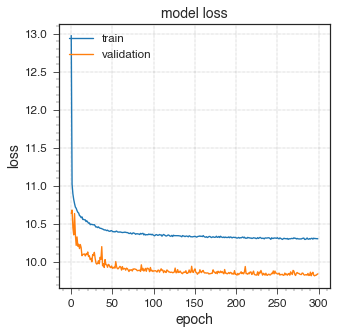

In [29]:
plt.figure(figsize=(5,5),dpi = 70)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [30]:
x = np.concatenate((x_train_displ, x_test_displ),axis = 0)
y = np.concatenate((y_train_displ, y_test_displ),axis = 0)
dxy = np.concatenate((dxy_train_displ, dxy_test_displ),axis = 0)
k_fold_validation(model = model, 
                  x = x, 
                  y = y, 
                  dxy = dxy, 
                  folds =50)

Average RMSE for 50-fold cv for y: 79.06990215617502
Average RMSE for 50-fold cv for dxy: 16.27243344908982


[INFO    ] # of entries: 1034656, mean: -0.03382112115543751, std: 16.23794399552425
[INFO    ] gaus fit (a, mu, sig): [6.83766317e+04 1.39188345e-02 1.10113168e+01]


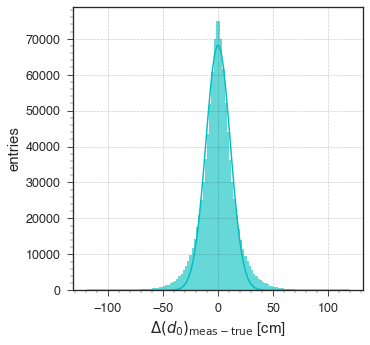

[INFO    ] # of entries: 1034656, mean: 0.045670753392419994, std: 0.18357138526457467
[INFO    ] gaus fit (a, mu, sig): [3.49308319e+04 4.99603957e-03 2.43344844e-01]


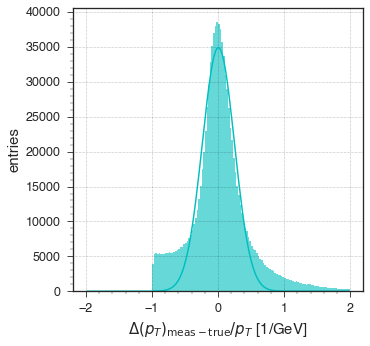

In [21]:
def __generate_delta_plots__(y,y_predicted,dxy,dxy_predicted):
    y_test_true = y.copy()
    y_test_true /= reg_pt_scale
    y_test_sel = (np.abs(1.0/y_test_true) >= 20./reg_pt_scale)
    dxy_test_true = dxy.copy()
    dxy_test_true /= reg_dxy_scale
    dxy_test_sel = (np.abs(dxy_test_true) >= 25)
    
    # Plot Delta(dxy) - (b)
    plt.figure(figsize=(5,5),dpi = 75)
    yy = (dxy_predicted - dxy_test_true)[y_test_sel]
    hist, edges, _ = plt.hist(yy, bins=120, range=(-120,120), histtype='stepfilled', facecolor='c', alpha=0.6)
    plt.xlabel(r'$\Delta(d_{0})_{\mathrm{meas-true}}$ [cm]')
    plt.ylabel(r'entries')
    logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy)))

    popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy))
    logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
    xdata = (edges[1:] + edges[:-1])/2
    plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='c')
    plt.show()   
    
    # Plot Delta(q/pT)/pT
    plt.figure(figsize=(5,5),dpi = 75)
    yy = ((np.abs(1.0/y_predicted) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true))
    hist, edges, _ = plt.hist(yy, bins=160, range=(-2.0,2.0-eps), histtype='stepfilled', facecolor='c', alpha=0.6)
    plt.xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}}/p_{T}$ [1/GeV]')
    plt.ylabel(r'entries')
    logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.4])))

    popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<2.0]))
    logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
    xdata = (edges[1:] + edges[:-1])/2
    plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='c')
    plt.show()

evaluate_obj = evaluate(x_test_displ, tuple([y_test_displ, dxy_test_displ]))
y_predicted , dxy_predicted = evaluate_obj.predict(model = model)
__generate_delta_plots__(y_test_displ, y_predicted, dxy_test_displ, dxy_predicted)

### Training Algorithm for Pruned Model:

In [11]:
import tensorflow_model_optimization as tfmot

In [12]:
# load json and create model
def loading_trained_model(filepath='', model_filename='model'):
    try:
        model_path = filepath + model_filename + ".json"
        model_weights_path = filepath + model_filename + "_weights.h5"
        json_file = open(model_path, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)
        # load weights into new model
        loaded_model.load_weights(model_weights_path)
        print("Loaded model from disk")
        
        return loaded_model
        
    except:
        print("ERROR: The model doesn't exist at the address provided.")
        
loaded_model = loading_trained_model(filepath = os.getcwd()+"/",model_filename = 'model')

Loaded model from disk


In [13]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 1000
epochs = 10
validation_split = 0.1 # 10% of training set will be used for validation set. 
lr = 1e-4
clipnorm = 10.

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(
                                                        target_sparsity = 0.50, 
                                                        begin_step = 0, 
                                                        end_step = -1, 
                                                        frequency = 1)
        }


model_for_pruning = prune_low_magnitude(loaded_model, **pruning_params)

# Set loss and optimizers
adam = optimizers.Adam(lr=lr, clipnorm=clipnorm)
model_for_pruning.compile(optimizer=adam,
              loss=huber_loss,
              metrics=['accuracy'])

model_for_pruning.summary()

/Users/gpradhan/opt/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_batch_no (None, 23)                93        
_________________________________________________________________
prune_low_magnitude_dense (P (None, 20)                922       
_________________________________________________________________
prune_low_magnitude_batch_no (None, 20)                81        
_________________________________________________________________
prune_low_magnitude_activati (None, 20)                1         
_________________________________________________________________
prune_low_magnitude_dense_1  (None, 15)                602       
_________________________________________________________________
prune_low_magnitude_batch_no (None, 15)                61        
_________________________________________________________________
prune_low_magnitude_activati (None, 15)                1

In [14]:
logger.info('Training model with l1_reg: {0} l2_reg: {0}'.format(l1_reg, l2_reg))
logdir = tempfile.mkdtemp()
history = train_model(model_for_pruning, 
                      x_train_displ, 
                      np.column_stack((y_train_displ, dxy_train_displ)),
                      epochs=epochs, 
                      batch_size=batch_size,
                      callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights, 
                                 tfmot.sparsity.keras.UpdatePruningStep(),
                                 tfmot.sparsity.keras.PruningSummaries(log_dir=logdir)], 
                      validation_split=validation_split, 
                      verbose=2)

metrics = [len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]]
logger.info('Epoch {0}/{0} - loss: {1} - val_loss: {2}'.format(*metrics))

[INFO    ] Training model with l1_reg: 0.0 l2_reg: 0.0
[INFO    ] Begin training ...


Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
2025/2025 - 9s - loss: 17.3813 - accuracy: 0.9042 - val_loss: 14.5742 - val_accuracy: 0.9198

Epoch 00001: val_loss did not improve from 9.73163

Epoch 00001: val_loss did not improve from 9.73163
Epoch 2/10

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
2025/2025 - 6s - loss: 13.8538 - accuracy: 0.9226 - val_loss: 13.0167 - val_accuracy: 0.9260

Epoch 00002: val_loss did not improve from 9.73163

Epoch 00002: val_loss did not improve from 9.73163
Epoch 3/10

Epoch 00003: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
2025/2025 - 6s - loss: 12.8407 - accuracy: 0.9263 - val_loss: 12.3552 - val_accuracy: 0.9282

Epoch 00003: val_loss did not improve from 9.73163

Epoch 00003: val_loss did not improve from 9.73163
Epoch 4/10

Epoch 00004: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
2025/2025 - 6s - loss: 12

[INFO    ] Done training. Time elapsed: 0:00:59.428356 sec
[INFO    ] Epoch 10/10 - loss: 11.457005500793457 - val_loss: 11.213362693786621



Epoch 00010: val_loss did not improve from 9.73163

Epoch 00010: val_loss did not improve from 9.73163


In [15]:
def get_sparsity(weights):
    """
    Code borrowed from https://github.com/google/qkeras/blob/master/qkeras/utils.py#L937
    Returns the sparsity as the ratio of non-zero weights to the total weights within the weights matrix.
    """
    return 1.0 - np.count_nonzero(weights) / float(weights.size)

In [16]:
for layer in model_for_pruning.layers:
    w = layer.get_weights()
    if len(w) == 1 or len(w) == 2:
        print(layer.name,":",get_sparsity(w[0]))

prune_low_magnitude_dense : 0.5
prune_low_magnitude_dense_1 : 0.5
prune_low_magnitude_dense_2 : 0.5
prune_low_magnitude_dense_3 : 0.5


In [17]:
#################### END ############################################################################################